# Export shock

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Find steady state and Jacobian](#toc2_)    
- 3. [Find IRF](#toc3_)    
- 4. [Figures](#toc4_)    


<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = BabyMAKROModelClass(name='baseline')           

**Unpack namespaces:**

In [3]:
par = model.par                 
ss = model.ss                   
sol = model.sol                

## 2. <a id='toc2_'></a>[Find steady state and Jacobian](#toc0_)

**Find SS:**

In [4]:
model.find_ss()                 

**Jacobian:**

In [5]:
model.compile(do_print=True)

model compiled, 51.9 secs


In [6]:
model.calc_jac(do_print=True)   

Jacobian calculated in 2.1 secs


## 3. <a id='toc3_'></a>[Find IRF](#toc0_)

**Set exogenous variables:**

In [7]:
model.set_exo_ss()              

**Define shock:**

In [8]:
Tshock = 25                                                                 # length of shock
persistence = np.array([np.exp(-0.1*np.arange(Tshock)**2)])                  # persistence of shock       
persistence = persistence.reshape((Tshock,1)) 
Priceshock = 0.003                                                             #Siz of shock

persistence_chi = np.array([np.exp(-np.arange(Tshock))])                    
persistence_chi = persistence_chi.reshape((Tshock,1))
chi_shock = 0.008            

persistence_r_hh = np.array([np.exp(-0.1*np.arange(Tshock)**2)])                    
persistence_r_hh = persistence_r_hh.reshape((Tshock,1))
r_hh_shock = 0.001     

model.sol.chi[:Tshock,:] = model.ss.chi*(1 + chi_shock*persistence_chi)     # the shock to chi is 2.5 times as large as the price shock
model.sol.r_hh[:Tshock,:] = model.ss.r_hh*(1+r_hh_shock*persistence_r_hh)  # Shock to interest rate
model.sol.P_F[:Tshock,:] = model.ss.P_F*(1 + Priceshock*persistence)        # shock to the foreign price
model.sol.P_M_C[:Tshock,:] = model.ss.P_M_C*(1 + Priceshock*persistence)    # shock to the consumption import price 
model.sol.P_M_G[:Tshock,:] = model.ss.P_M_G*(1 + Priceshock*persistence)    # shock to the government consumption import price  
model.sol.P_M_I[:Tshock,:] = model.ss.P_M_I*(1 + Priceshock*persistence)    # shock to the investment import price  
model.sol.P_M_X[:Tshock,:] = model.ss.P_M_X*(1 + Priceshock*persistence)    # shock to the export import price  

**Find IRF:**

In [9]:
model.find_IRF()              

initial:
t1-t0 = 0.02273 secs
it = 5
    max. abs. error = 2.73e-12
    8.75e-14 in A_R_ini_error
    3.12e-15 in Aq_diff
    2.66e-15 in FOC_capital_agency
    2.73e-12 in FOC_K_ell
    2.33e-12 in mkt_clearing
    8.97e-14 in PC

solve: t1-t0 = 0.11375 secs
evaluate + update: t3-t2 = 0.06142 secs


## 4. <a id='toc4_'></a>[Figures](#toc0_)

**Get data for emperical IRF**

In [10]:
empirical_IRF = pd.read_csv('data/empirical_IRF.csv')
#Only use data for foreign demand shock
empirical_IRF = empirical_IRF[(empirical_IRF['Shock'] == 'ForeignDemand')]


variables_data = empirical_IRF['Variable'].unique()
# Print the variables and shocks
print("Variable names in data set:")
print(variables_data)


Variable names in data set:
['log(GDP)' 'log(C)' 'log(IM)' 'log(IBx)' 'log(Ibol)' 'log(EX)'
 'MarkovUgap' 'log(PC)' 'log(PY)' 'log(W_rel)' 'log(PBol)' 'log(PEX)'
 'Sentiment' 'RF' 'PF' 'YF']


**Plot foreign demand shock IRF's from model results and data for relevant variables** 

In [11]:
# Map variable names from model to dataset
mapping = {'chi': 'YF', 'P_F': 'PF', 'r_hh' : 'RF', 'P_X': 'log(PEX)', 'P_Y': 'log(PY)', 'P_C': 'log(PC)', 'X': 'log(EX)', 'Y': 'log(GDP)', 'C': 'log(C)', 'real_W': 'log(W_rel)', 'U': 'MarkovUgap', 'I': 'log(IM)'}
variables = list(mapping.keys())

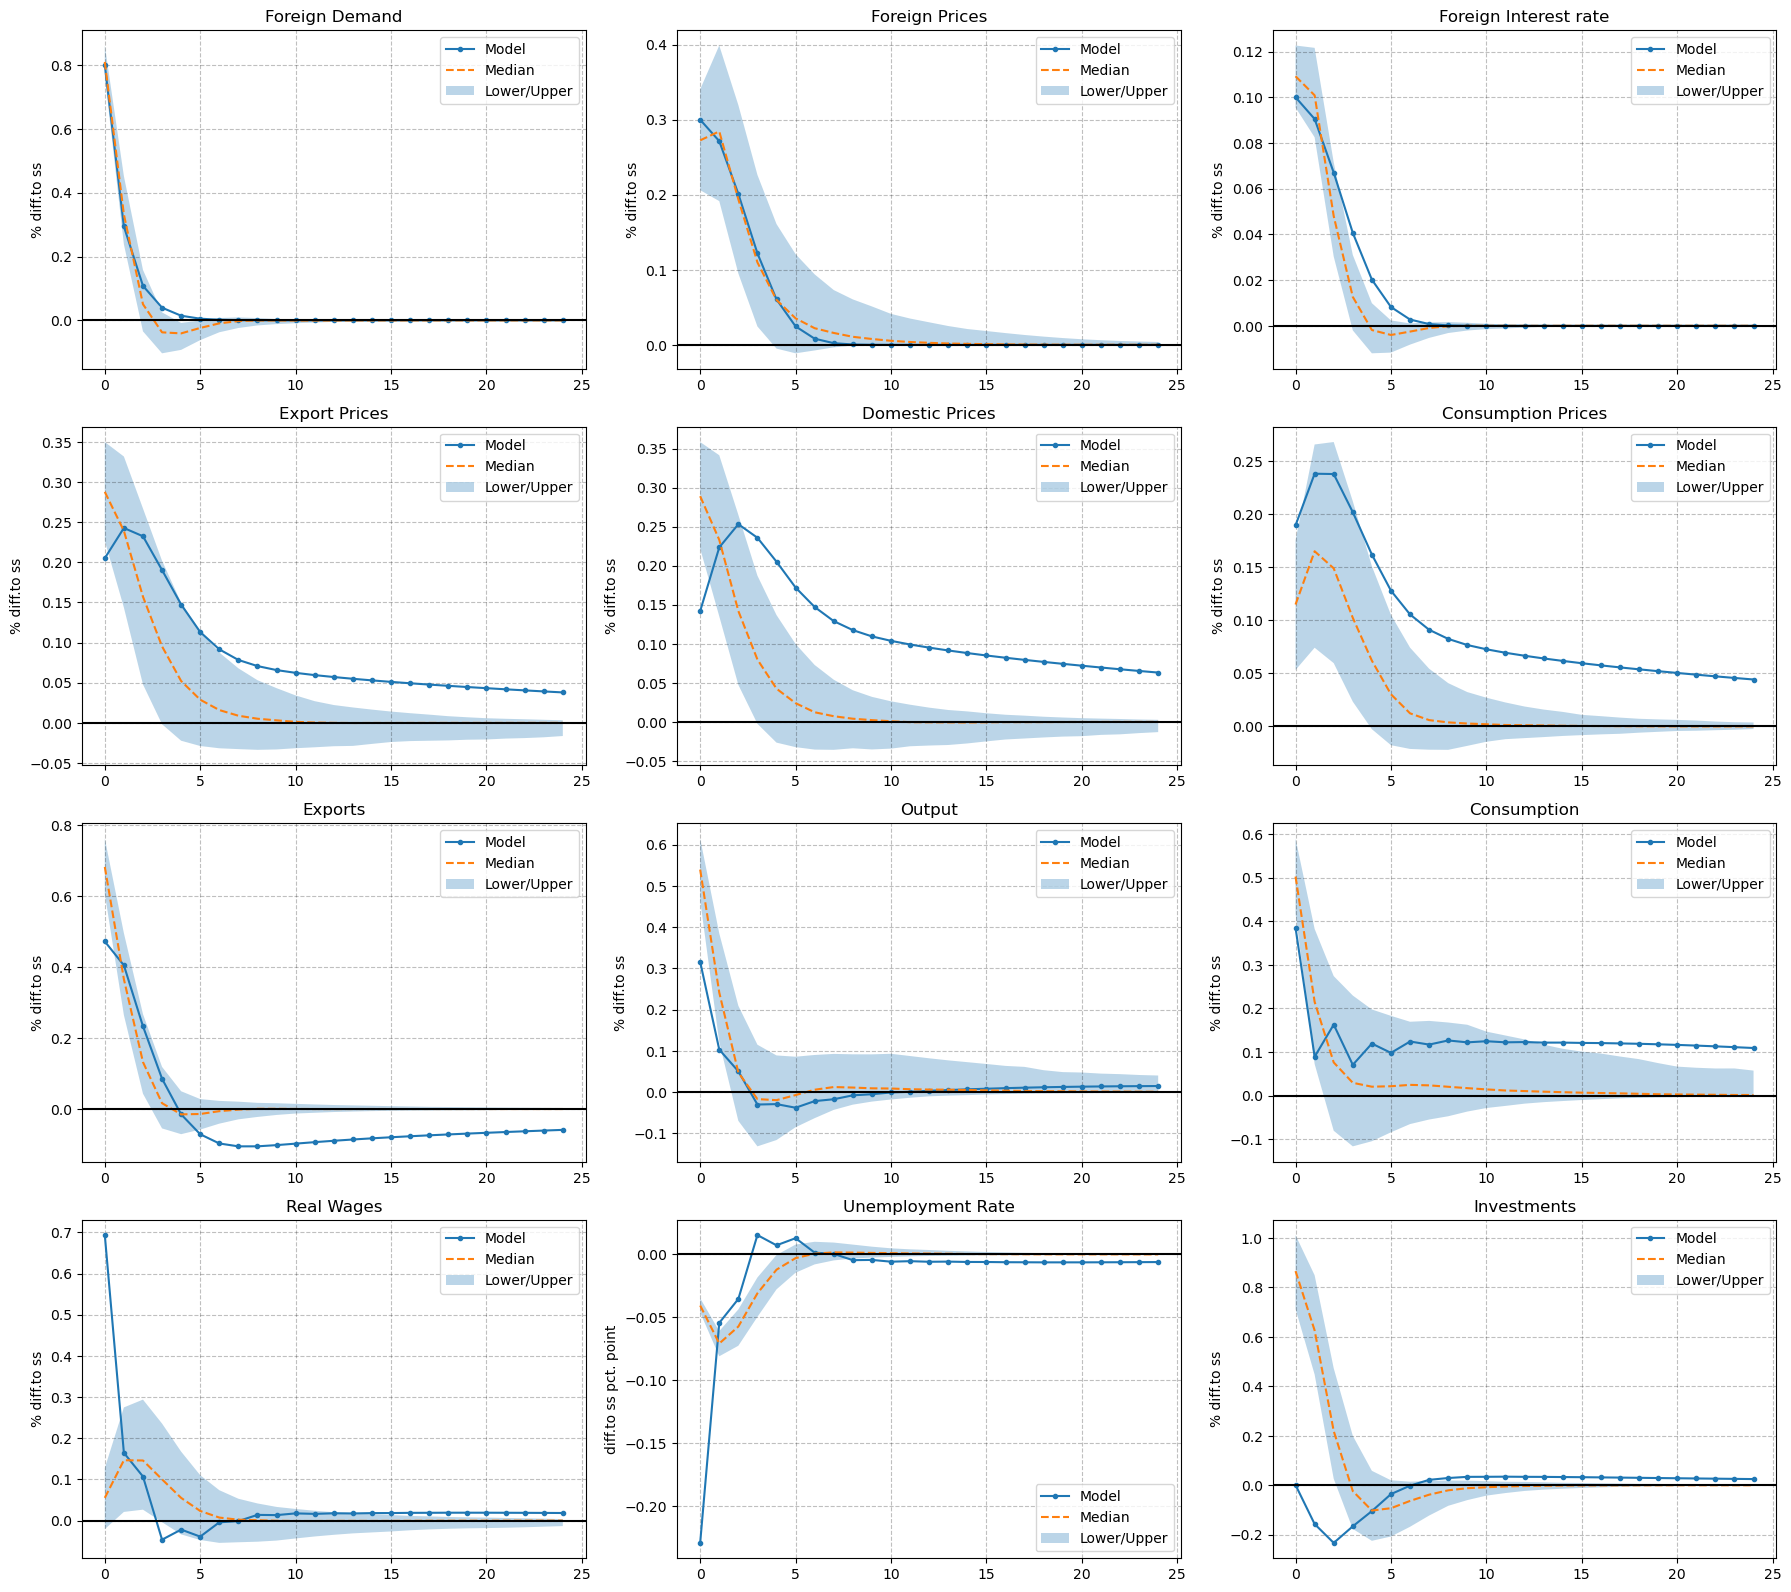

In [12]:

#Plot IRF's
def plot_IRF(self,varlist,ncol=3,T_IRF=25, abs = None,Y_share = None):
        """ plot IRFs """

        if abs is None:
            abs = []
        if Y_share is None:
            Y_share = []
                
        ss = self.ss
        sol = self.sol

        nrow = len(varlist)//ncol
        if len(varlist) > nrow*ncol: nrow+=1

        fig = plt.figure(figsize=(ncol*6,nrow*6/1.5))
        for i,varname in enumerate(varlist):

            ax = fig.add_subplot(nrow,ncol,1+i)

            path = sol.__dict__[varname]
            ssvalue = ss.__dict__[varname]

            empirical_variable = mapping.get(varname)
            shock_IRF = empirical_IRF[(empirical_IRF['Variable'] == empirical_variable)]
            
            if varname == 'U':
                ax.set_ylabel('diff.to ss pct. point')
                ax.plot((path[:T_IRF]-ssvalue),'-o',markersize=3, label='Model')
                ax.plot(shock_IRF['Time'], shock_IRF['Median'], linestyle='--', label='Median')
                plt.fill_between(shock_IRF['Time'], shock_IRF['Lower'], shock_IRF['Upper'], alpha=0.3, label='Lower/Upper')
            elif varname in abs:
                ax.axhline(ssvalue,color='black')
                ax.plot(path[:T_IRF],'-o',markersize=3, label='Model')
                ax.plot(shock_IRF['Time'], shock_IRF['Median'], linestyle='--', label='Median')
                plt.fill_between(shock_IRF['Time'], shock_IRF['Lower'], shock_IRF['Upper'], alpha=0.3, label='Lower/Upper')
            elif varname in Y_share:
                ax.axhline(ssvalue/ss.Y,color='black')
                ax.plot(path[:T_IRF]/sol.Y[:T_IRF],'-o',markersize=3, label='Model')   
                ax.set_ylabel('share of Y')       
                ax.plot(shock_IRF['Time'], shock_IRF['Median'], linestyle='--', label='Median')
                plt.fill_between(shock_IRF['Time'], shock_IRF['Lower'], shock_IRF['Upper'], alpha=0.3, label='Lower/Upper')  
            elif np.isclose(ssvalue,0.0):
                ax.plot(path[:T_IRF]-ssvalue,'-o',markersize=3, label='Model')
                ax.set_ylabel('diff.to ss')
                ax.plot(shock_IRF['Time'], shock_IRF['Median'], linestyle='--', label='Median')
                plt.fill_between(shock_IRF['Time'], shock_IRF['Lower'], shock_IRF['Upper'], alpha=0.3, label='Lower/Upper')
            else:
                ax.plot((path[:T_IRF]/ssvalue-1)*100,'-o',markersize=3, label='Model')
                ax.set_ylabel('% diff.to ss')
                ax.plot(shock_IRF['Time'], shock_IRF['Median'], linestyle='--', label='Median')
                plt.fill_between(shock_IRF['Time'], shock_IRF['Lower'], shock_IRF['Upper'], alpha=0.3, label='Lower/Upper')
            
            label = self.labels[varname]
            ax.axhline(0,color='black')
            ax.set_title(label)
            plt.legend()

        fig.tight_layout(pad=1.0)

plot_IRF(model, varlist=variables)



    